# Turnaround tuesday strategy

### Iteration 1

1. Today is Monday.
2. The close must be at least 1% lower than Friday’s close.
3. If one and two are true, then enter at the close.
4. Exit at the close on Tuesday.

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Importing the dataset

dataset = pd.read_csv('./Candle_data/^NSEI-5Y.csv') # Daily candlestick data for <XYZ> stock for the last 5 years 
dataset = dataset.iloc[::-1] # Reverse the dataset
dataset = dataset.reset_index(drop=True) # Reset the index
dataset = dataset.dropna() # Drop the NaN values
# Create a col for day of the week
dataset['Day'] = pd.to_datetime(dataset['Date']).dt.dayofweek

print(dataset.head())
print(dataset.tail())
print(dataset.shape)


         Date          Open          High           Low         Close  \
0  2023-12-07  20932.400391  20941.250000  20850.800781  20901.150391   
1  2023-12-06  20950.750000  20961.949219  20852.150391  20937.699219   
2  2023-12-05  20808.900391  20864.050781  20711.150391  20855.099609   
3  2023-12-04  20601.949219  20702.650391  20507.750000  20686.800781   
4  2023-12-01  20194.099609  20291.550781  20183.699219  20267.900391   

      Adj Close    Volume  Day  
0  20901.150391  275000.0    3  
1  20937.699219  359200.0    2  
2  20855.099609  421000.0    1  
3  20686.800781  381100.0    0  
4  20267.900391  265800.0    4  
            Date          Open          High           Low         Close  \
1230  2018-12-14  10784.500000  10815.750000  10752.099609  10805.450195   
1231  2018-12-13  10810.750000  10838.599609  10749.500000  10791.549805   
1232  2018-12-12  10591.000000  10752.200195  10560.799805  10737.599609   
1233  2018-12-11  10350.049805  10567.150391  10333.849609 

In [3]:
# Strategy rules,
# 1. Today is Monday.
# 2. The close must be at least 1% lower than Friday’s close.
# 3. If one and two are true, then enter at the close.
# 4. Exit at the close on Tuesday.

# Looping through the dataset to find the trades that match the strategy rules

trades = [] # List to store the trades
# dataset has a column 'Day' which has the day of the week
# Monday is 0 and Sunday is 6

for i in range(0, len(dataset)-1):
    try:
        # print(dataset['Day'][i])
        if dataset['Day'][i] == 0: # If today is Monday, we buy
            if dataset['Close'][i] <= 0.99*dataset['Close'][i+1]: # If the close is at least 1% lower than Friday’s close
                trades.append([dataset['Date'][i], dataset['Close'][i]]) # Enter at the close
            else:
                trades.append([dataset['Date'][i], None]) # No trade
        elif dataset['Day'][i] == 1: # If today is Tuesday, we sell if we have a trade
            # Check if a trade was entered yesterday
            if trades[-1][1] != None:
                trades.append([dataset['Date'][i], dataset['Close'][i]]) # Exit at the close
            else:
                trades.append([dataset['Date'][i], None])
        else:
            trades.append([dataset['Date'][i], None])
    except:
        print('Error at index: ', i, 'Date: ', dataset.iloc[i].Date)
        trades.append([dataset.iloc[i].Day, None])
        # Print the whole row
        # print(dataset.iloc[i])
        pass

Error at index:  757 Date:  2020-11-13
Error at index:  1021 Date:  2019-10-24
Error at index:  1219 Date:  2018-12-27


In [4]:
# Convert the trades list to a dataframe
trades = pd.DataFrame(trades, columns=['Date', 'Close'])
print(trades.head())
print('#'*50)
print(trades.tail())
print(trades.shape)

print(trades.dtypes)

         Date  Close
0  2023-12-07    NaN
1  2023-12-06    NaN
2  2023-12-05    NaN
3  2023-12-04    NaN
4  2023-12-01    NaN
##################################################
            Date  Close
1226  2018-12-20    NaN
1227  2018-12-19    NaN
1228  2018-12-18    NaN
1229  2018-12-17    NaN
1230  2018-12-14    NaN
(1231, 2)
Date      object
Close    float64
dtype: object


In [5]:
# Calculate the returns
trades['Returns'] = trades['Close'].pct_change()

# Calculate the cumulative returns
trades['Cumulative Returns'] = (1 + trades['Returns']).cumprod()

print(trades.head())

         Date  Close  Returns  Cumulative Returns
0  2023-12-07    NaN      NaN                 NaN
1  2023-12-06    NaN      NaN                 NaN
2  2023-12-05    NaN      NaN                 NaN
3  2023-12-04    NaN      NaN                 NaN
4  2023-12-01    NaN      NaN                 NaN


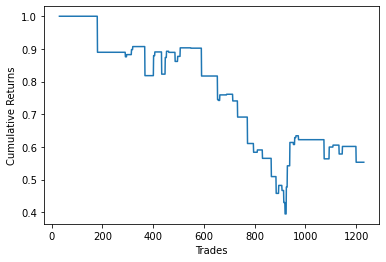

Mean:  -0.00040178122079048196
Sharpe ratio:  -0.029548699412892263
Maximum drawdown:  -0.6053133144035164
Annualized return:  -0.11175089518471715


In [6]:
# Plot the cumulative returns
import matplotlib.pyplot as plt
plt.plot(trades['Cumulative Returns'])
# Label the axes
plt.xlabel('Trades')
plt.ylabel('Cumulative Returns')
plt.show()

# Calculate the Sharpe ratio
# Sharpe ratio = (Mean portfolio return − Risk-free rate)/Standard deviation of portfolio return
# Risk-free rate = 0.07
# We will use the daily returns
daily_returns = trades['Returns']
sharpe_ratio = daily_returns.mean()/daily_returns.std()

print("Mean: ", daily_returns.mean())
print("Sharpe ratio: ", sharpe_ratio)

# Calculate the maximum drawdown
# Maximum drawdown = (Trough value − Peak value)/Peak value
# We will use the cumulative returns
cum_returns = trades['Cumulative Returns']
# Calculate the running maximum
running_max = np.maximum.accumulate(cum_returns.dropna())
# Ensure the value never drops below 1
running_max[running_max < 1] = 1
# Calculate the percentage drawdown
drawdown = (cum_returns)/running_max - 1

print("Maximum drawdown: ", drawdown.min())

# Calculate the annualized return
# Annualized return = ((1 + cumulative return)^(1/years)) − 1
# print it
print("Annualized return: ", (cum_returns.iloc[-1]**(1/5))-1)


### Iteration 2

1. Today is Monday.
2. The close must be lower than the open.
3. The IBS must be below 0.2.
4 If 1-3 are true, then enter at the close.
5. Sell at Tuesday’s close.

In [7]:
# Iteratio 2 rules,
# 1. Today is Monday.
# 2. The close must be lower than the open.
# 3. The IBS must be below 0.2.
# 4. If 1-3 are true, then enter at the close.
# 5. Sell at Tuesday’s close.

# Reload the dataset
dataset = pd.read_csv('./Candle_data/^NSEI-5Y.csv') # Daily candlestick data for <XYZ> stock for the last 5 years
dataset = dataset.iloc[::-1] # Reverse the dataset
dataset = dataset.reset_index(drop=True) # Reset the index
dataset = dataset.dropna() # Drop the NaN values
# Create a col for day of the week
dataset['Day'] = pd.to_datetime(dataset['Date']).dt.dayofweek

# Calculate the IBS
# IBS = (Close − Low)/(High − Low)
# We will use the daily data
IBS = (dataset['Close'] - dataset['Low'])/(dataset['High'] - dataset['Low'])
# Add the IBS to the dataset
dataset['IBS'] = IBS

print(dataset.head())

         Date          Open          High           Low         Close  \
0  2023-12-07  20932.400391  20941.250000  20850.800781  20901.150391   
1  2023-12-06  20950.750000  20961.949219  20852.150391  20937.699219   
2  2023-12-05  20808.900391  20864.050781  20711.150391  20855.099609   
3  2023-12-04  20601.949219  20702.650391  20507.750000  20686.800781   
4  2023-12-01  20194.099609  20291.550781  20183.699219  20267.900391   

      Adj Close    Volume  Day       IBS  
0  20901.150391  275000.0    3  0.556662  
1  20937.699219  359200.0    2  0.779142  
2  20855.099609  421000.0    1  0.941457  
3  20686.800781  381100.0    0  0.918678  
4  20267.900391  265800.0    4  0.780714  


In [8]:
# Looping through the dataset to find the trades that match the strategy rules

trades = [] # List to store the trades
# dataset has a column 'Day' which has the day of the week
# Monday is 0 and Sunday is 6

for i in range(0, len(dataset)-1):
    try:
        # print(dataset['Day'][i])
        if dataset['Day'][i] == 0: # If today is Monday, we buy
            if dataset['Close'][i] < dataset['Open'][i] and dataset['IBS'][i] < 0.2: # If the close is lower than the open and IBS is below 0.2
                trades.append([dataset['Date'][i], dataset['Close'][i]]) # Enter at the close
            else:
                trades.append([dataset['Date'][i], None]) # No trade
        elif dataset['Day'][i] == 1: # If today is Tuesday, we sell if we have a trade
            # Check if a trade was entered yesterday
            if trades[-1][1] != None:
                trades.append([dataset['Date'][i], dataset['Close'][i]]) # Exit at the close
            else:
                trades.append([dataset['Date'][i], None])
        else:
            trades.append([dataset['Date'][i], None])
    except:
        print('Error at index: ', i, 'Date: ', dataset.iloc[i].Date)
        trades.append([dataset.iloc[i].Day, None])
        # Print the whole row
        # print(dataset.iloc[i])
        pass

# Convert the trades list to a dataframe
trades = pd.DataFrame(trades, columns=['Date', 'Close'])
print(trades.head())

Error at index:  757 Date:  2020-11-13
Error at index:  1021 Date:  2019-10-24
Error at index:  1219 Date:  2018-12-27
         Date  Close
0  2023-12-07    NaN
1  2023-12-06    NaN
2  2023-12-05    NaN
3  2023-12-04    NaN
4  2023-12-01    NaN


In [9]:
# Calculate the returns
trades['Returns'] = trades['Close'].pct_change()

# Calculate the cumulative returns
trades['Cumulative Returns'] = (1 + trades['Returns']).cumprod()

print(trades.head())

         Date  Close  Returns  Cumulative Returns
0  2023-12-07    NaN      NaN                 NaN
1  2023-12-06    NaN      NaN                 NaN
2  2023-12-05    NaN      NaN                 NaN
3  2023-12-04    NaN      NaN                 NaN
4  2023-12-01    NaN      NaN                 NaN


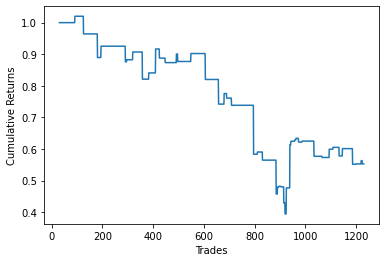

In [10]:
# Plot the cumulative returns
import matplotlib.pyplot as plt

plt.plot(trades['Cumulative Returns'])
# Label the axes
plt.xlabel('Trades')
plt.ylabel('Cumulative Returns')
plt.show()